<center>
<img src="https://image.aladin.co.kr/product/12609/37/cover500/k372532974_1.jpg" width="200" height="200"><br>
</center>

# 2장 서울시 범죄 현황 분석

이번에는 서울시의 범죄 현황 분석을 해보자. 구글에 '서울시 관서별 5대 범죄 발생 검거 현황' 이라는 키워드로 검색한 결과에 대한 데이터를 준비 하자. 자세한 데이터는 다음링크를 참고 하자.

 - Github: [PinkWink](https://github.com/PinkWink/DataScience)

### 2-1 pandas를 이용한 데이터 정리

먼저 numpy와 pandas를 import하자. 그리고 이제 이 데이터를 crime_anal_police로 저장 해놓자. 그리고 다음을 보면 서울시 경찰서별로 살인, 강도, 강간, 절도, 폭력이라는 5대 범죄에 대한 발생건수와 검거 건수를 갖고 있다.

In [5]:
import numpy as np
import pandas as pd
import json
import requests 


crime_anal_police = pd.read_csv("data/02. crime_in_Seoul.csv", thousands=',', 
                               encoding='euc-kr')

crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170
1,종로서,3,3,6,5,115,98,1070,413,1278,1070
2,남대문서,1,0,6,4,65,46,1153,382,869,794
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711
4,혜화서,3,2,5,4,96,63,1114,424,1015,861


여기서 문제가 하나 생긴다. 강남3구가 안전한지를 확인하려 할때 데이터가 관서별로 되어 있다. 서울시에는 한 구에 하나 혹은 두 군데의 경찰서가 위치해 있고, 구 이름과 다른 경찰서도 있다. 이 경찰서 목록을 소속 구별로 변경 하고 싶은데 이를 위해 이 정보를 알아야 한다. 이를 해결하기 위해 주소 데이터를 불러 오자.

### 2-1 Google Maps를 이용해서 주소와, 위도 경도 정보 얻기

위치에 대한 검색 결과중 주소와 위도, 경도 정보를 제공하는 서비스가 구글에 있다. Google Maps API라는건데 다음의 링크를 통해 Google Maps Geocoding API를 얻어주자.

 - [Google Map API](https://developers.google.com/maps?hl=ko)

In [6]:
# ! pip3 install googlemaps

In [7]:
import googlemaps

In [123]:
gmaps_key = "google map apikey"

In [122]:
gmaps = googlemaps.Client(key = gmaps_key)

In [9]:
gmaps.geocode('서울중부경찰서', language='ko')

[{'address_components': [{'long_name': '２７',
    'short_name': '２７',
    'types': ['premise']},
   {'long_name': '수표로',
    'short_name': '수표로',
    'types': ['political', 'sublocality', 'sublocality_level_4']},
   {'long_name': '을지로동',
    'short_name': '을지로동',
    'types': ['political', 'sublocality', 'sublocality_level_2']},
   {'long_name': '중구',
    'short_name': '중구',
    'types': ['political', 'sublocality', 'sublocality_level_1']},
   {'long_name': '서울특별시',
    'short_name': '서울특별시',
    'types': ['administrative_area_level_1', 'political']},
   {'long_name': '대한민국',
    'short_name': 'KR',
    'types': ['country', 'political']},
   {'long_name': '100-032',
    'short_name': '100-032',
    'types': ['postal_code']}],
  'formatted_address': '대한민국 서울특별시 중구 을지로동 수표로 27',
  'geometry': {'location': {'lat': 37.5636465, 'lng': 126.9895796},
   'location_type': 'ROOFTOP',
   'viewport': {'northeast': {'lat': 37.56499548029149,
     'lng': 126.9909285802915},
    'southwest': {'lat': 3

이렇게 Google Maps을 사용해서 '서울중부경찰서'라는 단어를 검색해 보았다. 이제 이를 이용해서 계속해서 전처리를 시작하자.

In [10]:
station_name = []

for name in crime_anal_police['관서명']:
    station_name.append('서울' + str(name[:-1]) + '경찰서')

station_name

['서울중부경찰서',
 '서울종로경찰서',
 '서울남대문경찰서',
 '서울서대문경찰서',
 '서울혜화경찰서',
 '서울용산경찰서',
 '서울성북경찰서',
 '서울동대문경찰서',
 '서울마포경찰서',
 '서울영등포경찰서',
 '서울성동경찰서',
 '서울동작경찰서',
 '서울광진경찰서',
 '서울서부경찰서',
 '서울강북경찰서',
 '서울금천경찰서',
 '서울중랑경찰서',
 '서울강남경찰서',
 '서울관악경찰서',
 '서울강서경찰서',
 '서울강동경찰서',
 '서울종암경찰서',
 '서울구로경찰서',
 '서울서초경찰서',
 '서울양천경찰서',
 '서울송파경찰서',
 '서울노원경찰서',
 '서울방배경찰서',
 '서울은평경찰서',
 '서울도봉경찰서',
 '서울수서경찰서']

이제 Google maps api 를 사용해 만들어 둔 경찰서 이름을 주소로 받아 오자.

In [12]:
station_address = []
station_lat = []
station_lng = []

for name in station_name:
    tmp = gmaps.geocode(name, language = 'ko')
    station_address.append(tmp[0].get("formatted_address"))
    
    tmp_loc = tmp[0].get('geometry')
    
    station_lat.append(tmp_loc['location']['lat'])
    station_lng.append(tmp_loc['location']['lng'])
    
    print(name + '->' + tmp[0].get("formatted_address"))

서울중부경찰서->대한민국 서울특별시 중구 을지로동 수표로 27
서울종로경찰서->대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46
서울남대문경찰서->대한민국 서울특별시 중구 회현동 한강대로 410
서울서대문경찰서->대한민국 서울특별시 서대문구 충현동 통일로 113
서울혜화경찰서->대한민국 서울특별시 종로구 인의동 창경궁로 112-16
서울용산경찰서->대한민국 서울특별시 용산구 원효로1가 백범로 329
서울성북경찰서->대한민국 서울특별시 성북구 삼선동 보문로 170
서울동대문경찰서->대한민국 서울특별시 동대문구 청량리동 약령시로21길 29
서울마포경찰서->대한민국 서울특별시 마포구 아현동 마포대로 183
서울영등포경찰서->대한민국 서울특별시 영등포구 영등포동1가 618-7
서울성동경찰서->대한민국 서울특별시 성동구 행당동 왕십리광장로 9
서울동작경찰서->대한민국 서울특별시 동작구 노량진1동 노량진로 148
서울광진경찰서->대한민국 서울특별시 광진구 구의동 자양로 167
서울서부경찰서->대한민국 서울특별시 은평구 녹번동 진흥로 58
서울강북경찰서->대한민국 서울특별시 강북구 번1동 오패산로 406
서울금천경찰서->대한민국 서울특별시 금천구 시흥1동 시흥대로73길 50
서울중랑경찰서->대한민국 서울특별시 중랑구 신내동 신내역로3길 40-10
서울강남경찰서->대한민국 서울특별시 강남구 대치동 테헤란로114길 11
서울관악경찰서->대한민국 서울특별시 관악구 청룡동 관악로5길 33
서울강서경찰서->대한민국 서울특별시 강서구 화곡동 화곡로 308
서울강동경찰서->대한민국 서울특별시 강동구 성내1동 성내로 57
서울종암경찰서->대한민국 서울특별시 성북구 종암동 종암로 135
서울구로경찰서->대한민국 서울특별시 구로구 구로동 가마산로 235
서울서초경찰서->대한민국 서울특별시 서초구 서초3동 반포대로 179
서울양천경찰서->대한민국 서울특별시 양천구 신정6동 목동동로 99
서울송파경찰서->대한민국 서울특별시 송파구 가락동 중대로 221
서울노원경찰서->대한민국 서울특

이렇게 각각 경찰서에 대한 정보를 확인할 수 있다.

In [20]:
print(station_address[0:5])
print(station_lat[0:5])
print(station_lng[0:5])

['대한민국 서울특별시 중구 을지로동 수표로 27', '대한민국 서울특별시 종로구 종로1.2.3.4가동 율곡로 46', '대한민국 서울특별시 중구 회현동 한강대로 410', '대한민국 서울특별시 서대문구 충현동 통일로 113', '대한민국 서울특별시 종로구 인의동 창경궁로 112-16']
[37.5636465, 37.575548, 37.5547584, 37.5647439, 37.5718529]
[126.9895796, 126.9847471, 126.9734981, 126.9667705, 126.9989143]


In [22]:
gu_name = []

for name in station_address:
    tmp = name.split()
    
    tmp_gu = [gu for gu in tmp if gu[-1] == '구'][0]
    
    gu_name.append(tmp_gu)

crime_anal_police['구별'] = gu_name
crime_anal_police.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


이중에서 금천경찰서의 경우에는 관악구에 있어서 따로 전처리를 진행 해주자.

In [24]:
crime_anal_police.loc[crime_anal_police['관서명'] == '금천서', ['구별']] = '금천구'
crime_anal_police[crime_anal_police['관서명'] == '금천서']

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
15,금천서,3,4,6,6,151,122,1567,888,2054,1776,금천구


### 2-2 pandas의 pivot_table 학습

이번에는 pandas의 pivot_table을 학읍 해보자. 

In [25]:
import pandas as pd
import numpy as np

In [28]:
df = pd.read_csv("data/02. sales-funnel.csv")
df.head()

,Account,Name,Rep,Manager,Product,Quantity,Price,Status
0,714466,Trantow-Barrows,Craig Booker,Debra Henley,CPU,1,30000,presented
1,714466,Trantow-Barrows,Craig Booker,Debra Henley,Software,1,10000,presented
2,714466,Trantow-Barrows,Craig Booker,Debra Henley,Maintenance,2,5000,pending
3,737550,"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,CPU,1,35000,declined
4,146832,Kiehn-Spinka,Daniel Hilton,Debra Henley,CPU,2,65000,won


이 데이터에서 Name 항목으로만 정렬하고자 할때 pivot_table을 사용한다. 다음을 보자.

In [36]:
pd.pivot_table(df, index=["Name"])

,Account,Price,Quantity
Name,,,
Barton LLC,740150,35000,1.000000
"Fritsch, Russel and Anderson",737550,35000,1.000000
Herman LLC,141962,65000,2.000000
Jerde-Hilpert,412290,5000,2.000000
"Kassulke, Ondricka and Metz",307599,7000,3.000000
Keeling LLC,688981,100000,5.000000
Kiehn-Spinka,146832,65000,2.000000
Koepp Ltd,729833,35000,2.000000
Kulas Inc,218895,25000,1.500000


index를 여러개 지정할 수도 있다 

In [38]:
pd.pivot_table(df, index=["Name", "Rep", "Manager"])

,,,Account,Price,Quantity
Name,Rep,Manager,,,
Barton LLC,John Smith,Debra Henley,740150,35000,1.000000
"Fritsch, Russel and Anderson",Craig Booker,Debra Henley,737550,35000,1.000000
Herman LLC,Cedric Moss,Fred Anderson,141962,65000,2.000000
Jerde-Hilpert,John Smith,Debra Henley,412290,5000,2.000000
"Kassulke, Ondricka and Metz",Wendy Yule,Fred Anderson,307599,7000,3.000000
Keeling LLC,Wendy Yule,Fred Anderson,688981,100000,5.000000
Kiehn-Spinka,Daniel Hilton,Debra Henley,146832,65000,2.000000
Koepp Ltd,Wendy Yule,Fred Anderson,729833,35000,2.000000
Kulas Inc,Daniel Hilton,Debra Henley,218895,25000,1.500000


특정 value만 지정해서 나나타게 할 수도 있다.

In [32]:
pd.pivot_table(df, index=["Manager", "Rep"], values=["Price"])

Price
Manager       Rep                        
Debra Henley  Craig Booker   20000.000000
              Daniel Hilton  38333.333333
              John Smith     20000.000000
Fred Anderson Cedric Moss    27500.000000
              Wendy Yule     44250.000000

value를 pivot_table로 합친 경우 default로 평균치를 계산하게 된다. 여기에서 합계를 사용하려면 aggfunc옵션을 사용해서 np.sum를 사용해주자.

In [39]:
pd.pivot_table(df, index=["Manager", "Rep"], values="Price", aggfunc=np.sum)

Price
Manager       Rep                  
Debra Henley  Craig Booker    80000
              Daniel Hilton  115000
              John Smith      40000
Fred Anderson Cedric Moss    110000
              Wendy Yule     177000

다음의 코드를 사용한 결과를 보자.Index를 지정하고, values를 지정한다. 그리고 합산(np.sum)과 평균(np.mean)을 표시하도록 하고, 그 과정에서 빈 칸이 나타나면 NaN으로 두지 말고 fill_value옵션을 이용해서 0으로 채우는 코드이다.

In [40]:
pd.pivot_table(df, index=["Manager", "Rep", "Product"],
              values=["Price", "Quantity"],
              aggfunc=[np.sum, np.mean], fill_value=0, margins=True)

sum                   mean  \
                                          Price Quantity         Price   
Manager       Rep           Product                                      
Debra Henley  Craig Booker  CPU           65000        2  32500.000000   
                            Maintenance    5000        2   5000.000000   
                            Software      10000        1  10000.000000   
              Daniel Hilton CPU          105000        4  52500.000000   
                            Software      10000        1  10000.000000   
              John Smith    CPU           35000        1  35000.000000   
                            Maintenance    5000        2   5000.000000   
Fred Anderson Cedric Moss   CPU           95000        3  47500.000000   
                            Maintenance    5000        1   5000.000000   
                            Software      10000        1  10000.000000   
              Wendy Yule    CPU          165000        7  82500.000000   
                            Maintenance    7000        3   7000.000000   
                            Monitor        5000        2   5000.000000   
All                                      522000       30  30705.882353   

                                                   
                                         Quantity  
Manager       Rep           Product                
Debra Henley  Craig Booker  CPU          1.000000  
                            Maintenance  2.000000  
                            Software     1.000000  
              Daniel Hilton CPU          2.000000  
                            Software     1.000000  
              John Smith    CPU          1.000000  
                            Maintenance  2.000000  
Fred Anderson Cedric Moss   CPU          1.500000  
                            Maintenance  1.000000  
                            Software     1.000000  
              Wendy Yule    CPU          3.500000  
                            Maintenance  3.000000  
                            Monitor      2.000000  
All                                      1.764706

### 2-3 Pivot_table을 이용해서 데이터 정리 하기

In [42]:
crime_anal_raw = pd.read_csv("data/02. crime_in_Seoul_include_gu_name.csv")
crime_anal_raw.head()

,Unnamed: 0,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별
0,0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구
1,1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구
2,2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구
3,3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구
4,4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구


이 데이터 또한 pivot_table를 이용하여 원 데이터를 관서별에서 구별로 바꾸면 다음과 같다.

In [44]:
crime_anal_raw = pd.read_csv("data/02. crime_in_Seoul_include_gu_name.csv",
                            index_col=0)
crime_anal = pd.pivot_table(crime_anal_raw, index = '구별', aggfunc=np.sum)
crime_anal.head()

,강간 검거,강간 발생,강도 검거,강도 발생,살인 검거,살인 발생,절도 검거,절도 발생,폭력 검거,폭력 발생
구별,,,,,,,,,,
강남구,349,449,18,21,10,13,1650,3850,3705,4284
강동구,123,156,8,6,3,4,789,2366,2248,2712
강북구,126,153,13,14,8,7,618,1434,2348,2649
관악구,221,320,14,12,8,9,827,2706,2642,3298
광진구,220,240,26,14,4,4,1277,3026,2180,2625


추가로 각 범죄별 검거율을 계산하고 검거 건수는 제거 해주자.

In [45]:
crime_anal['강간검거율'] = crime_anal['강간 검거']/crime_anal['강간 발생']*100
crime_anal['강도검거율'] = crime_anal['강도 검거']/crime_anal['강도 발생']*100
crime_anal['살인검거율'] = crime_anal['살인 검거']/crime_anal['살인 발생']*100
crime_anal['절도검거율'] = crime_anal['절도 검거']/crime_anal['절도 발생']*100
crime_anal['폭력검거율'] = crime_anal['폭력 검거']/crime_anal['폭력 발생']*100

del crime_anal['강간 검거']
del crime_anal['강도 검거']
del crime_anal['살인 검거']
del crime_anal['절도 검거']
del crime_anal['폭력 검거']

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,133.333333,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,114.285714,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,116.666667,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,185.714286,100.000000,42.200925,83.047619


그런데 검거율이 100이 넘는 숫자들이 있다. 이는 전년도 발생 건수에 대한 검거도 포함되어 있어서 그런 것 같아 보이며 이를 처리 하기 위해 100이 넘는 것들은 100으로 우선 치환 해주자.

In [46]:
con_list = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

for column in con_list:
    crime_anal.loc[crime_anal[column] > 100, column] = 100

crime_anal.head()

,강간 발생,강도 발생,살인 발생,절도 발생,폭력 발생,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


이제 뒤에 붙은 발생이라는 단어를 삭제 하자.

In [47]:
crime_anal.rename(columns = {'강간 발생':'강간',
                            '강도 발생':'강도',
                            '살인 발생':'살인',
                            '절도 발생':'절도',
                            '폭력 발생':'폭력'}, inplace = True)
crime_anal.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,449,21,13,3850,4284,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,156,6,4,2366,2712,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,153,14,7,1434,2649,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,320,12,9,2706,3298,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,240,14,4,3026,2625,91.666667,100.000000,100.000000,42.200925,83.047619


### 2-4 데이터 다듬기

위의 데이터를 보면 강도,살인 사건은 두자리수인데 반해 절도와 폭력은 네자리수이다. 데이터를 다루는데 있어서 이를 처리하는데 절도와 폭력에 많은 가중치가 들어갈수 있기 때문에 이를 정규화 시켜주는 작업을 진행해보자. 파이썬 머신러닝에 모듈로 유명한 scikit learn에 있는 전처리 도구를 사용해주면 된다.

In [50]:
# !pip3 install sklearn

In [55]:
from sklearn import preprocessing

col = ['강간', '강도', '살인', '절도', '폭력']

x = crime_anal[col].values
min_max_scaler = preprocessing.MinMaxScaler()

x_scaled = min_max_scaler.fit_transform(x.astype(float))
crime_anal_norm = pd.DataFrame(x_scaled,
                              columns=col,
                              index=crime_anal.index)

col2 = ['강간검거율','강도검거율','살인검거율','절도검거율','폭력검거율']
crime_anal_norm[col2] = crime_anal[col2]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율
구별,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619


이제 1장에서 진행 했더 CCTV_resule.csv를 가져오자.

In [56]:
result_CCTV = pd.read_csv('data/01. CCTV_result.csv', encoding='utf-8',
                         index_col='구별')

crime_anal_norm[['인구수', 'CCTV']] = result_CCTV[['인구수', '소계']]
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV
구별,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707


In [57]:
col = ['강간', '강도', '살인', '절도', '폭력']
crime_anal_norm['범죄'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄
구별,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438


In [58]:
col = ['강간', '강도', '살인', '절도', '폭력']
crime_anal_norm['검거'] = np.sum(crime_anal_norm[col], axis=1)
crime_anal_norm.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701,4.472701
강동구,0.155620,0.058824,0.166667,0.445775,0.289667,78.846154,100.000000,75.000000,33.347422,82.890855,453233.0,773,1.116551,1.116551
강북구,0.146974,0.529412,0.416667,0.126924,0.274769,82.352941,92.857143,100.000000,43.096234,88.637222,330192.0,748,1.494746,1.494746
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667,2.613667
광진구,0.397695,0.529412,0.166667,0.671570,0.269094,91.666667,100.000000,100.000000,42.200925,83.047619,372164.0,707,2.034438,2.034438


### 2-5 편리한 시각화 도구 seaborn

이번에는 Seaborn이라는 시각화 도구를 사용해보자. Matplotlib와 함깨 사용하는 시각화 도구로, 알아두면 매우 편리 하다.

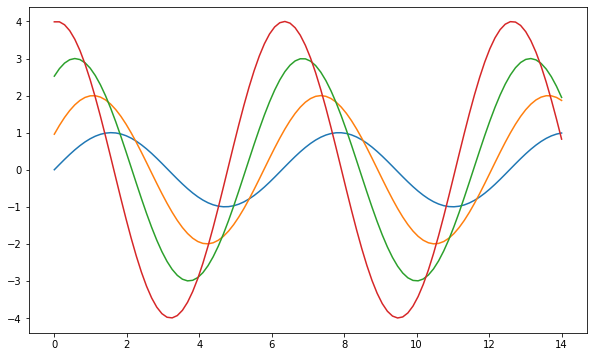

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

x = np.linspace(0,14,100)
y1 = np.sin(x)
y2 = 2*np.sin(x + 0.5)
y3 = 3*np.sin(x + 1.0)
y4 = 4*np.sin(x + 1.5)

plt.figure(figsize = (10,6))
plt.plot(x, y1, x,y2, x,y3, x,y4)
plt.show()

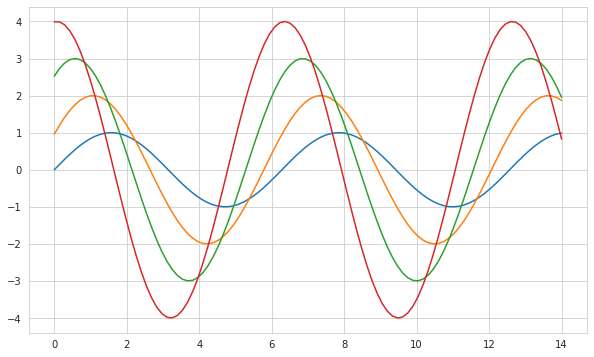

In [61]:
sns.set_style("whitegrid")

plt.figure(figsize = (10,6))
plt.plot(x, y1, x,y2, x,y3, x,y4)
plt.show()

#### Seaborn의 기본 데이터

Seaborn은 기본 데이터 넷을 가지고 있다. 다음의 코드를 보자. Tips라는 데이터셋으로, 요일별 점심, 저녁, 흡연 여부와 식사 금액과 팁을 정리한 데이터 이다.

In [63]:
tips = sns.load_dataset('tips')
tips.head(5)

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


boxplot을 그리는데 x축에는 요일, y축에는 전체 금액을 그릴 수 있다.

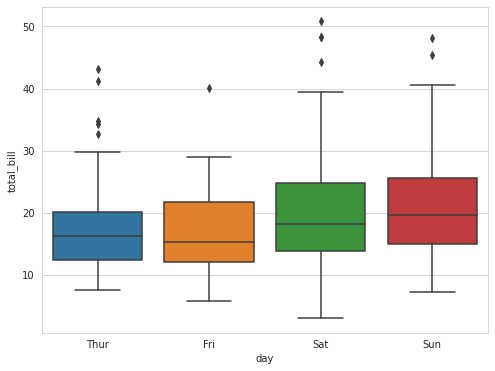

In [64]:
plt.figure(figsize = (8,6))
sns.boxplot(x="day", y = 'total_bill', data=tips)
plt.show()

이번에는 hue옵션을 사용해 구분을 해보자.

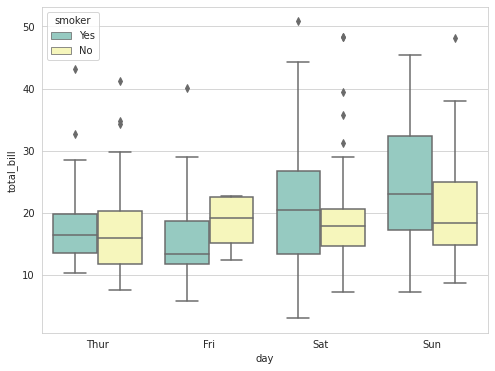

In [66]:
plt.figure(figsize = (8,6))
sns.boxplot(x="day", y = 'total_bill', hue='smoker',data=tips, palette="Set3")
plt.show()

이번에는 darkgrid 스타일로 하고 lmplot를 그려보자. 데이터를 scatter처럼 그리고 직선으로 regression한 그림도 추가 해준다. 

/home/owen/.local/lib/python3.6/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


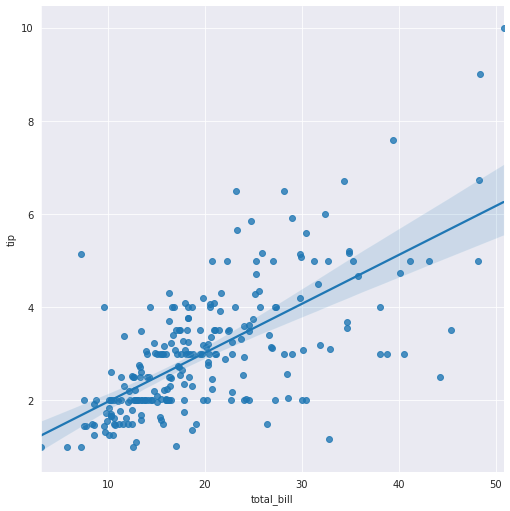

In [67]:
sns.set_style("darkgrid")
sns.lmplot(x="total_bill", y="tip", data=tips, size=7)
plt.show()

추가로 hue옵션을 주어 palette로 색상을 지정할 수도 있다.

/home/owen/.local/lib/python3.6/site-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


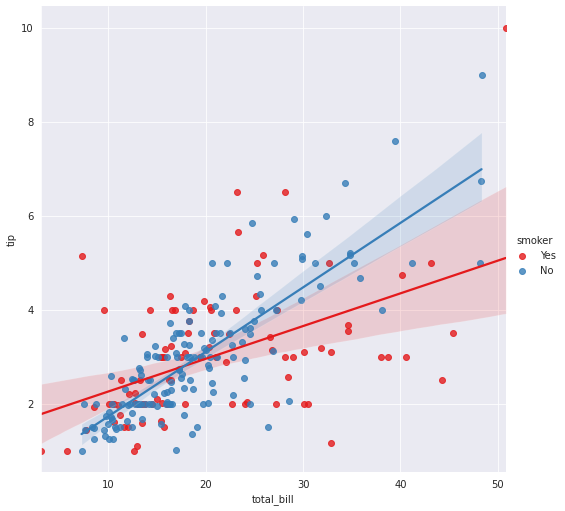

In [68]:
sns.lmplot(x="total_bill", y="tip", hue="smoker", data=tips, palette="Set1", size=7)
plt.show()

이번에는 연도 및 월별 항공기 승객수를 기록한 데이터를 보자.

In [69]:
flights = sns.load_dataset("flights")
flights.head(5)

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


이 데이터에 대해 연도 및 월별 항공기 승객수를 기록한 데이터를 보자.

In [71]:
flights = flights.pivot("month", "year", "passengers")
flights.head(5)

year,1949,1950,1951,1952,1953,1954,1955,1956,1957,1958,1959,1960
month,,,,,,,,,,,,
Jan,112,115,145,171,196,204,242,284,315,340,360,417
Feb,118,126,150,180,196,188,233,277,301,318,342,391
Mar,132,141,178,193,236,235,267,317,356,362,406,419
Apr,129,135,163,181,235,227,269,313,348,348,396,461
May,121,125,172,183,229,234,270,318,355,363,420,472


이를 시각화 하기 위해서는 heatmap를 사용해 경향을 보면 매우 편리 하다. 다음의 코드를 보자.

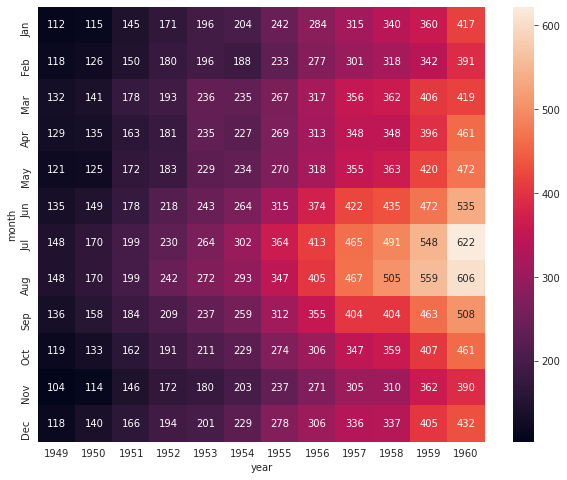

In [72]:
plt.figure(figsize = (10,8))
sns.heatmap(flights, annot=True, fmt='d')
plt.show()

이번에는 머신러닝에서 주로 사용되는 iris데이터를 알아보자.

In [73]:
sns.set(style='ticks')
iris = sns.load_dataset("iris")
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


iris데이터의 데이터를 보기 위해 pairplot이라는 메서드를 사용해 전반적인 데이터 파악을 진행 해보자.

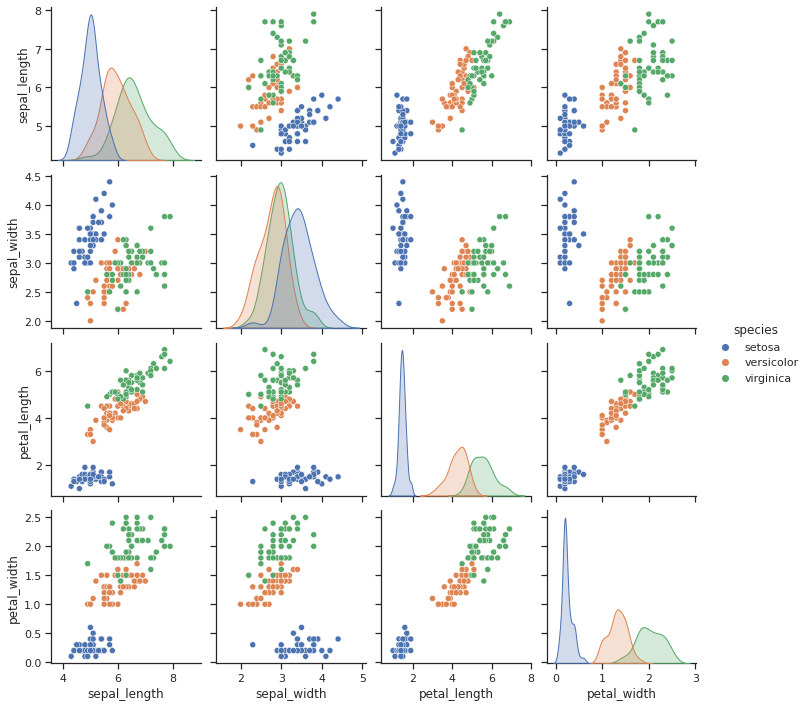

In [74]:
sns.pairplot(iris, hue="species")
plt.show()

### 2-6 범죄 데이터 시각화 

이번에는 범죄 데이터를 시각화 해보자. 먼저 폰트 문제를 해결해주자.

In [75]:
import platform

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system() == 'Linux':
    path = "/usr/share/fonts/NanumFont/NanumGothic.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    plt.rc('font', family=font_name)
else:
    print('Unknown system... sorry~~~~')

pairplot으로 강도, 살인, 폭력 간의 상관관계를 그래프로 그려보자. 이때 강도와 폭력, 살인과 폭력, 강도와 살인 모두 양의 상관관계가 보인다.

/home/owen/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


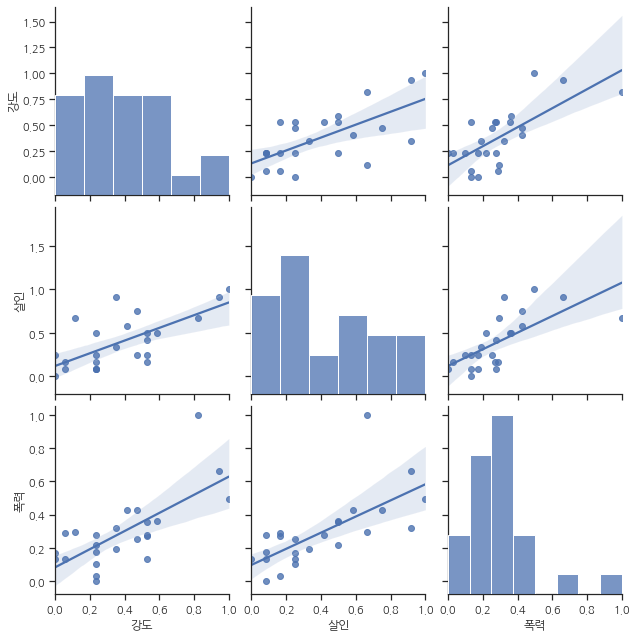

In [77]:
sns.pairplot(crime_anal_norm, vars =["강도", "살인", "폭력"], kind='reg', size = 3)
plt.show()

이번에는 인구수와 CCTV 개수, 그리고 살인과 강도에 대해 조사해보자. 전체적인 상관계수는 CCTV와 살인의 관계가 낮을지 몰라도 CCTV가 없을 때 살인이 많이 일어나는 구간이 있다. 즉, CCTV개수를 기준으로 좌측면에 살인과 강도의 높은 수를 갖는 데이터가 보인다.

/home/owen/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


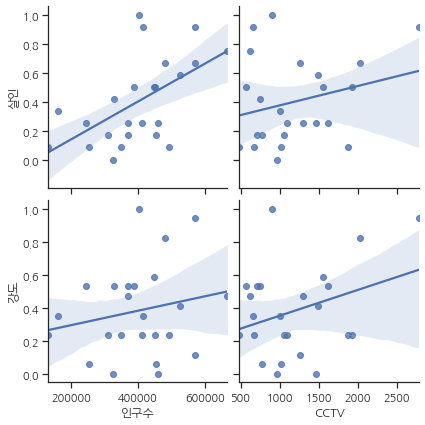

In [78]:
sns.pairplot(crime_anal_norm, 
             x_vars=["인구수", "CCTV"],
             y_vars=["살인", "강도"], 
            kind='reg', size=3)
plt.show()

이번에는 살인 및 폭력 검거율과 CCTV를 파악해보려 한다. 오히려 음의 상관계수도 보이기 때문에 이를 파악해보자.

/home/owen/.local/lib/python3.6/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


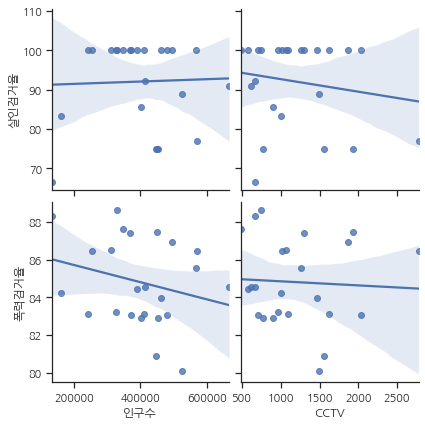

In [79]:
sns.pairplot(crime_anal_norm, 
             x_vars=["인구수", "CCTV"],
             y_vars=["살인검거율", "폭력검거율"], 
            kind='reg', size=3)
plt.show()

이번에는 검거율의 합계인 검거 항목의 최고값을 100으로 한정하고 그 값으로 정렬해보자.

In [80]:
tmp_max = crime_anal_norm['검거'].max()
crime_anal_norm['검거'] = crime_anal_norm['검거'] / tmp_max * 100
crime_anal_norm_sort = crime_anal_norm.sort_values(by='검거', ascending=False)
crime_anal_norm_sort.head()

,강간,강도,살인,절도,폭력,강간검거율,강도검거율,살인검거율,절도검거율,폭력검거율,인구수,CCTV,범죄,검거
구별,,,,,,,,,,,,,,
강남구,1.000000,0.941176,0.916667,0.953472,0.661386,77.728285,85.714286,76.923077,42.857143,86.484594,570500.0,2780,4.472701,100.000000
양천구,0.806916,0.823529,0.666667,1.000000,1.000000,77.486911,84.210526,100.000000,48.469644,83.065080,479978.0,2034,4.297113,96.074212
영등포구,0.556196,1.000000,1.000000,0.650359,0.493024,62.033898,90.909091,85.714286,32.995951,82.894737,402985.0,904,3.699580,82.714658
송파구,0.340058,0.470588,0.750000,0.744441,0.427524,80.909091,76.923077,90.909091,34.856437,84.552352,667483.0,618,2.732611,61.095311
관악구,0.628242,0.411765,0.583333,0.562094,0.428234,69.062500,100.000000,88.888889,30.561715,80.109157,525515.0,1496,2.613667,58.435995


위의 데이터를 통해 heatmap을 그려보자. 다음의 결과를 보면 절도 검거율은 다른 검거율에 비해 낮다는 것을 알 수 있다. 그리고 그래프의 하단으로 갈 수록 검거율이 낮은데 그 속에 강남3구 중에서 '서초구'가 보인다. 전반적으로 검거율이 우수한 구는 '도봉구', '광진구', '성동구'로 보여진다.

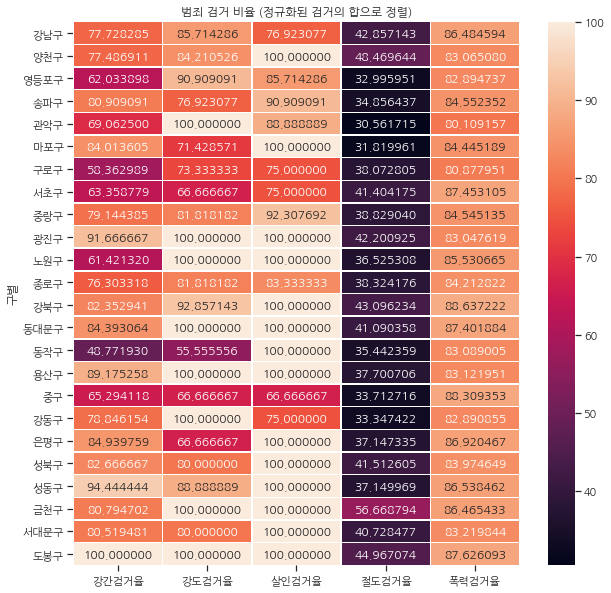

In [81]:
target_col = ['강간검거율', '강도검거율', '살인검거율', '절도검거율', '폭력검거율']

crime_anal_norm_sort = crime_anal_norm.sort_values(by = '검거', ascending=False)

plt.figure(figsize = (10,10))
sns.heatmap(crime_anal_norm_sort[target_col], annot=True, fmt='f', linewidth=.5)
plt.title("범죄 검거 비율 (정규화된 검거의 합으로 정렬)")
plt.show()

이번에는 발생 건수의 합으로 정렬시켜놓고 heatmap을 파악해보자. 발생 건수로 보니 강남구, 양천구, 영등포구가 범죄 발생건수가 높다. 그리고 송파구와 서초구도 낮다고 볼 수 없다. 그렇다면 강남3구가 정말 안전하다고 할 수 있을지 의문이 먼저 생기기 시작한다.

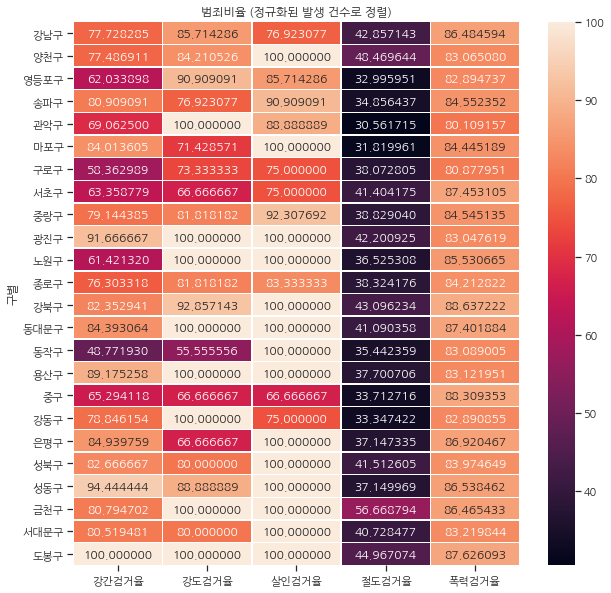

In [84]:
tartget_col = ['강간', '강도', '살인', '절도', '폭력', '범죄']

crime_anal_norm['범죄'] = crime_anal_norm['범죄'] / 5
crime_anal_norm_sort = crime_anal_norm.sort_values(by='범죄', ascending=False)
plt.figure(figsize = (10,10))

sns.heatmap(crime_anal_norm_sort[target_col], annot=True, fmt='f', linewidths=.5)
plt.title('범죄비율 (정규화된 발생 건수로 정렬)')
plt.show()

### 2-7 지도 시각화 도구 - Folium

이번에는 지도데이터를 사용해 표현을 해주자. Folium 라이브러리를 사용할것이다.

In [86]:
# !pip3 install folium

In [88]:
import folium

위도와 경도 정보를 주면 지됴를 그려준다. 다음과 같이 간단하게 확인 가능하다.

In [91]:
map_osm = folium.Map(location=[45.5236,-122.6750], zoom_start = 13)
map_osm

이번에는 지도를 그리고 그 상태에서 원하는 좌표에 Marker 명령으로 마크를 찍을 수 있게 하는 코드이다.

In [94]:
map_2 = folium.Map(location=[45.5236,-122.6750], zoom_start = 13)

folium.Marker([45.5244, -122.6699], popup='The Waterfront').add_to(map_2)
folium.CircleMarker([45.5215, -122.6261], radius = 50,
                   popup='Laurelhurst Park', color='#3186cc',
                   fill_color='#3186cc').add_to(map_2)
map_2

이번에는 json파일을 가지고 행정구역의 경계를 그려 보자.

In [96]:
state_unemployment = "data/02. folium_US_Unemployment_Oct2012.csv"

state_data = pd.read_csv(state_unemployment)
state_data.head()

,State,Unemployment
0,AL,7.1
1,AK,6.8
2,AZ,8.1
3,AR,7.2
4,CA,10.1


In [99]:
state_geo = 'data/02. folium_us-states.json'

map = folium.Map(location=[40,-98], zoom_start=4)
map.choropleth(geo_data=state_geo, data=state_data,
              columns=['State', 'Unemployment'],
              key_on='feature.id',
              fill_color='YlGn',
              legend_nam='Unemployment Rate (%)')

map

### 2-7 서울시 범죄율에 대한 지도 시각화

이렇게 지도 다루는 법을 알았으니 이를 시각화 해보자. 국내의 행정구역 json을 장 정리 해놓은 깃을 먼저 참고 하자 Lucy Park님의 깃헙을 출처로 남겨 놓는다. 
 - [Lucy Park님의 Github](https://github.com/southkorea/southkorea-maps)

In [101]:
import json

geo_path = 'data/02. skorea_municipalities_geo_simple.json'
geo_str = json.load(open(geo_path, encoding = 'utf-8'))

위와 같이 파이썬데이터주무르기의 공식 깃헙에서 준비해 놓은 json을 먼저 준비해놓자. 그리고 다음의 코드를 통해 살인 발생 건수를 파악해보자. 

In [102]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str, 
              data = crime_anal_norm['살인'],
              columns = [crime_anal_norm.index, crime_anal_norm['살인']],
              fill_color = 'PuRd', 
              key_on = 'feature.id')

map

이번에는 강간 발생건수로 그려보자. 

In [106]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str, 
              data = crime_anal_norm['강간'],
              columns = [crime_anal_norm.index, crime_anal_norm['강간']],
              fill_color = 'PuRd', 
              key_on = 'feature.id')

map

이번에는 범죄 관련해서 그려보자.

In [105]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11,
                tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str, 
              data = crime_anal_norm['범죄'],
              columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
              fill_color = 'PuRd', 
              key_on = 'feature.id')

map

이번에는 인구수를 고려해서 시각화를 해보자. 인구 대비 범죄 발생 비율을 알아보는것이다. 다음의 코드를 통해 파악해보자.

In [110]:
tmp_criminal = crime_anal_norm['살인'] / crime_anal_norm['인구수'] * 10000000

map = folium.Map(location = [37.5502, 126.982], zoom_start=11,
                tiles = 'Stamen Toner')

map.choropleth(geo_data = geo_str,
              data = tmp_criminal, 
              columns = [crime_anal.index, tmp_criminal],
              fill_color = 'PuRd',
              Key_on = 'feature.id')

map

### 2-8 서울시 경찰서별 검거율과 구별 범죄 발생율을 동시에 시각화

이제 조금더 진행 해서 경찰서별 검거율과 방금 전까지 수행한 범죄 발생율을 동시에 표현하는 코드를 알아보자.

In [114]:
crime_anal_raw['lat'] = station_lat
crime_anal_raw['lng'] = station_lng

col = ['살인 검거', '강도 검거', '강간 검거', '절도 검거', '폭력 검거']
tmp = crime_anal_raw[col] / crime_anal_raw[col].max()

crime_anal_raw['검거'] = np.sum(tmp, axis=1)

crime_anal_raw.head()

,관서명,살인 발생,살인 검거,강도 발생,강도 검거,강간 발생,강간 검거,절도 발생,절도 검거,폭력 발생,폭력 검거,구별,lat,lng,검거
0,중부서,2,2,3,2,105,65,1395,477,1355,1170,중구,37.563646,126.989580,1.275416
1,종로서,3,3,6,5,115,98,1070,413,1278,1070,종로구,37.575548,126.984747,1.523847
2,남대문서,1,0,6,4,65,46,1153,382,869,794,중구,37.554758,126.973498,0.907372
3,서대문서,2,2,5,4,154,124,1812,738,2056,1711,서대문구,37.564744,126.966770,1.978299
4,혜화서,3,2,5,4,96,63,1114,424,1015,861,종로구,37.571853,126.998914,1.198382


이제 이 데이터를 기준으로 경찰서의 위치를 시각화 해보자.

In [117]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11)

for n in crime_anal_raw.index:
    folium.Marker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]]).add_to(map)
    
map

이번에는 검거에 정당한 값을 곱해서 원 넓이를 정하고, 경찰서의 검거율을 원의 넓이로 표현해보자. 이를 통해 각 경찰서에 위치에서 넓은 원을 가지면 검거율이 높다고 보면 된다. 

In [118]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11)

for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]],
                       radius = crime_anal_raw['검거'][n] * 10,
                       color = '#3186cc', fill_color = '#3186cc').add_to(map)
    
map

이제 색상으라 붉은색으로 해서 범죄 발생 건수를 넣어서 파악해보자. 다음의 결과를 보면 범죄가 많이 일어날수록 붉은색이고, 그 속에서 원이 넓을수록 큰 원을 가진 경찰서들이 배치 된다. 그러며 서울 서부는 범죄는 많이 발생하지만 원 또한 넓다. 서울 강북의 중앙부는 경찰서의 검거율도 높지 않지만, 범죄 발생 건수도 높지 않다. 

In [119]:
map = folium.Map(location = [37.5502, 126.982], zoom_start = 11)

map.choropleth(geo_data = geo_str,
              data = crime_anal_norm['범죄'],
              columns = [crime_anal_norm.index, crime_anal_norm['범죄']],
              fill_color = 'PuRd',
              key_on = 'feature.id')

for n in crime_anal_raw.index:
    folium.CircleMarker([crime_anal_raw['lat'][n], crime_anal_raw['lng'][n]],
                       radius = crime_anal_raw['검거'][n] * 10,
                       color = '#3186cc', fill_color = '#3186cc').add_to(map)
    
map

/home/owen/.local/lib/python3.6/site-packages/folium/folium.py:413: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning
